# Atomic models for image simulation with ASE <a id='top'></a>

This notebook introduces the Atomic Simulation Environment ([ASE](https://wiki.fysik.dtu.dk/ase/)) for creating atomic models for image simulation.

ASE is a set of tools and Python modules for setting up, manipulating and visualizing atomic structures, the library is used in conjunction with a large number of atomistic simulation codes, for example [GPAW](https://wiki.fysik.dtu.dk/gpaw/) for running DFT simulations. In this notebook, ASE is introduced in the context of running electron microscopy image simulations with [*ab*TEM](https://abtem.github.io/doc/intro.html). 

### Contents:

1. <a href='#the_atoms_object'> The Atoms object
2. <a href='#importing_structures'> Importing structures from files
3. <a href='#visualization'> Visualization
4. <a href='#manipulating'> Manipulating the atoms
5. <a href='#exporting_structures'> Exporting structures to files
6. <a href='#orthogonal'> Orthogonal and periodic supercells

In [1]:
%matplotlib inline

import abtem
import ase
import matplotlib.pyplot as plt
import numpy as np
from ase.visualize import view

##  The `Atoms` object <a id='the_atoms_object'></a>

The `Atoms` object defines a collection of atoms. To define `Atoms` from scratch, we need to specify at least three things:

* atomic positions
* atomic numbers 
* a periodic cell

Here, we create a basic model of the N<sub>2</sub> molecule.

In [2]:
atoms = ase.Atoms("N2", positions=[(0.0, 0.0, 0.0), (1.0, 0.0, 0.0)], cell=[6, 6, 6])

__Note__: abTEM and ASE uses the same unit conventions, as defined in the `ase.units` module. Thus, electron volts (eV), Ångström (Å), and atomic mass units are defined as 1.0.

We can access the corresponding properties as below.

In [3]:
atoms.positions

array([[0., 0., 0.],
       [1., 0., 0.]])

In [4]:
atoms.numbers

array([7, 7])

In [5]:
atoms.cell

Cell([6.0, 6.0, 6.0])

The `Atoms` can be modified by directly changing the underlying NumPy arrays. Here we create NO.

In [6]:
atoms.numbers[0] = 9

We can add an additional N atom to create nitrous oxide.

In [7]:
atoms += ase.Atoms("N", positions=[(2.0, 0, 0)])

atoms

Atoms(symbols='FN2', pbc=False, cell=[6.0, 6.0, 6.0])

## Visualization <a id='visualization'></a>

We can visualize the atoms using the Matplotlib backend with abTEM's `show_atoms` function. This function shows a 2D projection of the structure perpendicular to a specified plane.

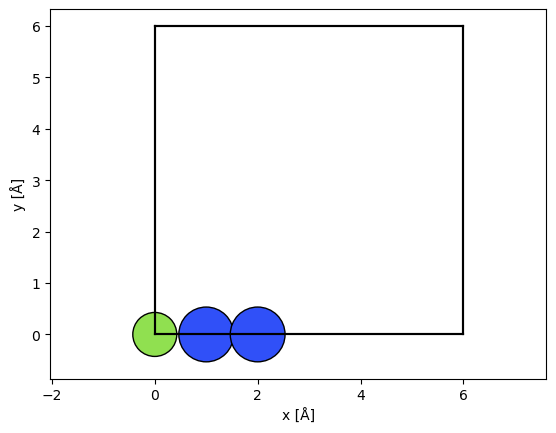

In [8]:
abtem.show_atoms(atoms);

The default ASE GUI, an interactive 3D viewer, may be started using the `view` function.

In [9]:
from ase.visualize import view

view(atoms)

<Popen: returncode: None args: ['C:\\Users\\jacob\\miniconda3\\envs\\abtem-s...>

## Importing structures from files <a id='importing_structures'></a>

ASE can import all the common atomic structure formats, see a full list [here](https://wiki.fysik.dtu.dk/ase/ase/io/io.html). Below we import a `.cif`-file defining a unit cell of strontium titanate (SrTiO<sub>3</sub>).

(<Figure size 640x480 with 1 Axes>, <Axes: xlabel='x [Å]', ylabel='y [Å]'>)

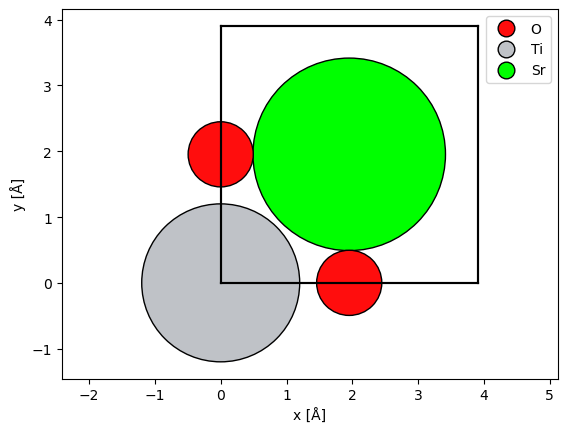

In [13]:
srtio3 = ase.io.read("srtio3.cif")

abtem.show_atoms(srtio3, legend=True)

In [11]:
view(srtio3)

<Popen: returncode: None args: ['C:\\Users\\jacob\\miniconda3\\envs\\abtem-s...>

## Manipulating the atoms <a id='manipulating'></a>
abTEM always assumes that the imaging electrons propagate along the $z$-axis in the direction from _negative to positive_ coordinate values. Hence, to choose the zone axis, we need to manipulate the atoms so they are properly aligned.

ASE has a large number of tools for manipulating imported structures, so we can't cover all of them here. As an example, we will look at the `surface` function, which can be used for creating a periodic surface (aligned with the $z$-axis) with a given set of Miller indices.

Here we orient the strontium titanate structure along the (110)-direction.

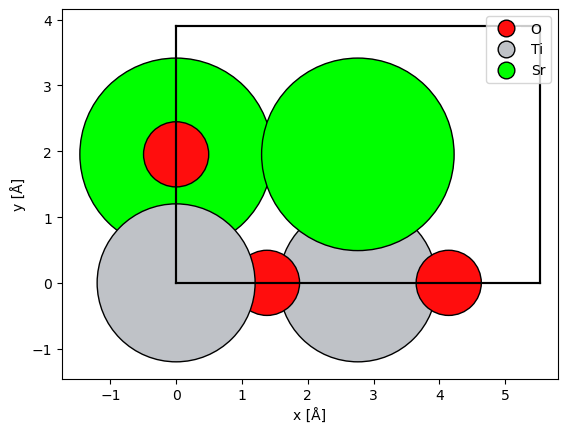

In [14]:
from ase.build import surface

srtio3_110 = surface(srtio3, indices=(1, 1, 0), layers=2, periodic=True)

abtem.show_atoms(srtio3_110, plane="xy", legend=True);

Simulations may require a larger crystal, to repeat the atoms by 2 in $x$, 4 in $y$ and 10 in the $z$-direction, we just multiply the atoms.

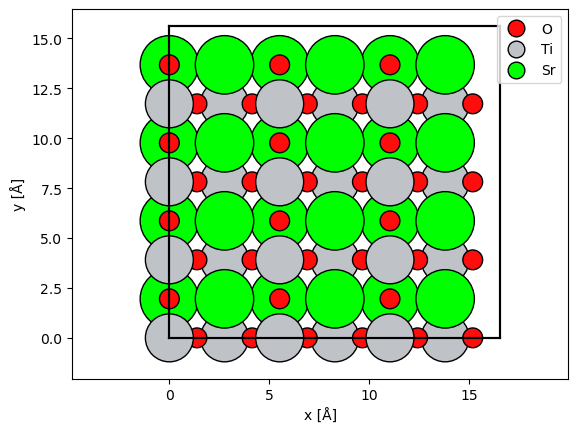

In [15]:
repeated_srtio3 = srtio3_110.copy()

repeated_srtio3 = srtio3_110 * (3, 4, 10)

abtem.show_atoms(repeated_srtio3, legend=True);

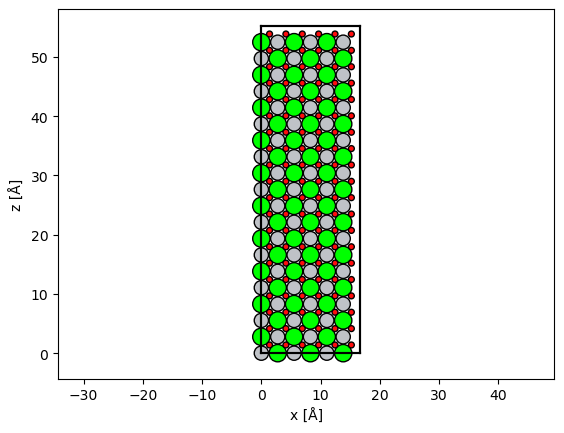

In [16]:
abtem.show_atoms(repeated_srtio3, plane="xz");

The positions and atomic numbers are just `numpy` arrays and hence can be modified in-place. Here, we create an SrTiO<sub>3</sub>/LaTiO<sub>3</sub> interface by changing the atomic numbers of the Sr atoms with a $y$-coordinate less than $7.5 \ \mathrm{Å}$.

In [34]:
sto_lto = repeated_srtio3.copy()

mask = sto_lto.symbols == "Sr"

mask = mask * (sto_lto.positions[:, 1] < 7.5)

sto_lto.numbers[mask] = 57

Next, we center the atoms in the cell and add $5 \ \mathrm{Å}$ of vacuum at the entrance and exit surfaces along the $z$-axis.

In [35]:
sto_lto.center(axis=2, vacuum=5)

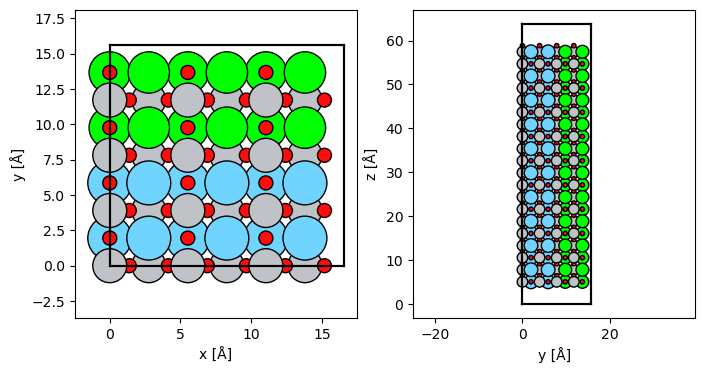

In [36]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
abtem.show_atoms(sto_lto, ax=ax1)
abtem.show_atoms(sto_lto, ax=ax2, plane="yz");

## Exporting structures to files <a id='exporting_structures'></a>

The structures can also be exported in all the common atomic structure formats. Here, we export the manipulated structure as `.cif`, so we can use it in the next tutorial. 

In [37]:
from ase.io import write

write("sto_lto.cif", sto_lto)

/opt/anaconda3/envs/abtem-dask/lib/python3.9/site-packages/ase/io/cif.py:787: UserWarning: Occupancies present but no occupancy info for "{symbol}"
  warnings.warn(str(err))


## Orthogonal and periodic supercells <a id='orthogonal'></a>

The multislice algorithm requires an orthogonal periodic atomic structure as its input. However, taking any arbitrary structure and making it periodic and orthogonal is not always trivial. abTEM has a tool for solving this problem.

To demonstrate the tool, we create a graphene structure with the minimal hexagonal unit cell. 

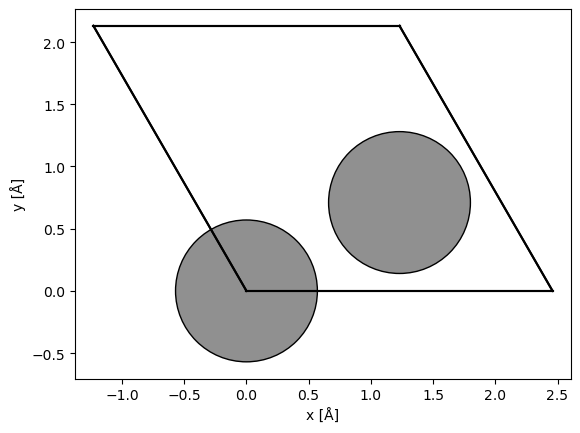

In [22]:
graphene = ase.build.graphene(vacuum=2, a=2.46)

abtem.show_atoms(graphene);

Applying `orthogonalize_cell` we find the smallest orthogonal version of a cell. 

In [18]:
from abtem.atoms import pretty_print_transform

In [21]:
pretty_print_transform(transform)

Euler angles (degrees): 	 x = 0.000, 	 y = -0.000, 	 z = 0.000
Normal strains (percent): 	 x = 0.000, 	 y = 0.000, 	 z = 0.000
Shear strains (percent): 	 xy = 0.000, 	 xz = 0.000, 	 xz = 0.000


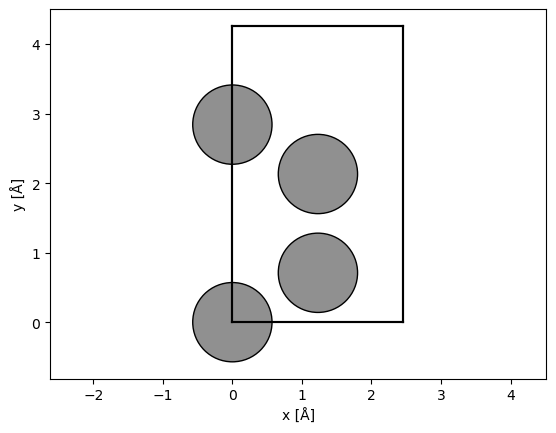

In [20]:
orthogonal_graphene, transform = abtem.orthogonalize_cell(graphene, return_transform=True)

abtem.show_atoms(orthogonal_graphene);

The problem of creating orthogonal cells is not always as trivial for graphene. For those interested in more advanced uses of the `orthogonalize_cell` function, we have a [tutorial](https://abtem.readthedocs.io/en/latest/tutorials/orthogonal_cells.html) dedicated to the subject.